## Introduction

AirSeaFluxCode is developed to provide an easy and accessible way to calculate turbulent surface fluxes (TSFs) from a small number of bulk variables and for a viariety of bulk algorithms. 

By running AirSeaFluxCode you can compare different bulk algorithms and to also investigate the effect choices within the implementation of each parameterisation have on the TSFs estimates. 


### Getting started

Let's first import the basic python packages we will need for reading in our input data, to perform basic statistics  and plotting

In [1]:
# first import all packages you might need
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import xarray_regrid
import numpy as np
import pandas as pd
import datetime
from glob import glob
from tabulate import tabulate
from src import AirSeaFluxCode

## Air sea flux code on gridded data

In [2]:
# TODO: precip needs to be aggregated

In [3]:
# 1 second per 6 hours in SYPD
secs_per_6hr_step = 0.2
secs_per_day = secs_per_6hr_step * 4
secs_per_year = secs_per_day*365
print(secs_per_year / 60)
sypd = (24*60*60) / secs_per_year
print(sypd)

4.866666666666666
295.8904109589041


In [4]:
fps = glob('/Users/bobbyantonio/repos/AirSeaFluxCode/sample_era5_data/*20070203.nc')

var_name_lookup = {'z': 'geopotential', 'q': 'specific_humidity'}

surface_fps = [fp for fp in fps if 'hPa' not in fp]
surface_ds = xr.merge([xr.load_dataset(fp) for fp in surface_fps])

plevel_fps = [fp for fp in fps if 'hPa' in fp]

plevel_ds = []
for var in ['z', 'q']:
    tmp_fps = [fp for fp in plevel_fps if var_name_lookup[var] in fp]
    tmp_ds = xr.concat([xr.load_dataset(fp).drop_vars('expver') for fp in sorted(tmp_fps)], dim='pressure_level')

    plevel_ds.append(tmp_ds)
plevel_ds = xr.merge(plevel_ds)

ds = xr.merge([surface_ds, plevel_ds]).sel(time=pd.date_range(start=datetime.datetime(2007,2,3), end=datetime.datetime(2007,2,3,6), freq='1h')).isel(time=0)


plevels = ds['pressure_level'].values
ds['q'] = ds['q'] * 1000 # Convert to g/kg

# Expand pressure levels out
for var in ['z', 'q']:
    for p in plevels:
        ds[f'{var}_{int(p)}'] = ds[var].sel(pressure_level=p)
        
ds = ds.drop_vars('expver').drop_vars('number').drop_vars('q').drop_vars('z').drop_vars('pressure_level')

ds['wind_speed'] = np.sqrt(ds['u10']**2 + ds['v10']**2)

ds['msl'] = ds['msl'] / 100 # Convert to hPA
ds['ewss'] = ds['ewss'] / (60*60) # Convert from integrated stress to mean stress
ds['ewss'] = ds['nsss'] / (60*60)
ds['surface_stress_magnitude'] = np.sqrt(ds['iews']**2 + ds['inss']**2)
# ds['q'] = ds['q']*1000 

# Interpolate humidity to surface
ds['q_surface'] = ds['q_1000'] + (ds['q_1000'] - ds['q_975']) * (ds['msl'] - 1000) / 25

# ds = ds.sel(longitude=[255.5, 255.75], method='nearest').sel(latitude=[9.5, 9.75], method='nearest')
df = ds.to_dataframe().reset_index()

df = df[~np.isnan(df['sst'])].reset_index()
df.head()


,index,latitude,longitude,time,mslhf,skt,v10,tp,msdwswrf,slhf,...,t2m,msnswrf,siconc,z_1000,z_975,q_1000,q_975,wind_speed,surface_stress_magnitude,q_surface
0,68458,-78.25,194.50,2007-02-03,-33.193604,272.365509,-4.803379,0.000042,355.56250,-119505.0,...,270.791359,207.96875,0.0,-576.30835,1388.363037,2.682138,2.600599,7.943013,0.131494,2.657968
1,68459,-78.25,194.75,2007-02-03,-39.099854,272.955353,-4.826970,0.000031,341.90625,-140753.0,...,270.823329,257.81250,0.0,-569.80835,1394.363037,2.643991,2.564360,8.130394,0.129947,2.620654
2,68460,-78.25,195.00,2007-02-03,-45.021729,273.545197,-4.850561,0.000020,328.25000,-162065.0,...,270.855298,307.68750,0.0,-563.30835,1400.488037,2.605844,2.528597,8.317707,0.128273,2.583478
3,68461,-78.25,195.25,2007-02-03,-44.990479,273.394806,-4.819106,0.000021,332.09375,-161937.0,...,270.755394,311.25000,0.0,-556.68335,1406.738037,2.555300,2.477098,8.367542,0.128515,2.532959
4,68462,-78.25,195.50,2007-02-03,-44.959229,273.242462,-4.787652,0.000021,336.00000,-161873.0,...,270.655490,314.87500,0.0,-549.43335,1413.363037,2.504278,2.425600,8.416466,0.129176,2.482099


In [5]:
# # Createa a 2 degrees version. Just using bilinear for now to see speed
target_dataset = xr.Dataset(
    {
        'latitude': (['latitude'], np.arange(-90, 90 + 2, 2)),
        'longitude': (['longitude'], np.arange(0, 360, 2)),
    }
)

ds_2deg = ds.unify_chunks().regrid.linear(target_dataset)

df_2deg = ds_2deg.to_dataframe().reset_index()

df_2deg = df_2deg[~np.isnan(df_2deg['sst'])].reset_index()
df_2deg.head()

,index,latitude,longitude,time,mslhf,skt,v10,tp,msdwswrf,slhf,...,t2m,msnswrf,siconc,z_1000,z_975,q_1000,q_975,wind_speed,surface_stress_magnitude,q_surface
0,1178,-78,196,2007-02-03,-34.756104,272.806915,-4.730641,8.630753e-05,280.37500,-125137.0,...,271.039120,262.90625,0.000000,-569.05835,1397.863037,2.700735,2.621103,8.409259,0.122408,2.677518
1,1179,-78,198,2007-02-03,-29.646729,271.701447,-3.883341,5.960464e-05,283.34375,-106705.0,...,270.343791,247.90625,0.000000,-501.93335,1458.363037,2.435137,2.350737,7.650635,0.104860,2.413400
2,1342,-76,164,2007-02-03,-24.240479,272.195587,0.846599,5.531311e-05,474.71875,-87249.0,...,269.638471,375.68750,0.294037,-363.43335,1585.988037,1.985479,1.917768,1.378772,0.007390,1.972688
3,1343,-76,166,2007-02-03,-27.756104,272.054962,-2.304729,4.768372e-07,481.46875,-99921.0,...,270.056069,381.50000,0.284637,-367.80835,1585.863037,1.883913,1.809526,2.703310,0.018063,1.869773
4,1344,-76,168,2007-02-03,-16.568604,272.094025,-0.240540,0.000000e+00,507.34375,-59601.0,...,269.330768,444.43750,0.125458,-355.68335,1594.863037,1.744676,1.699854,0.288263,0.000567,1.736405


In [6]:
print(df.columns)

Index(['index', 'latitude', 'longitude', 'time', 'mslhf', 'skt', 'v10', 'tp',
       'msdwswrf', 'slhf', 'ewss', 'nsss', 'sst', 'p140209', 'u10', 'sshf',
       'msshf', 'tauoc', 'msl', 'inss', 'iews', 't2m', 'msnswrf', 'siconc',
       'z_1000', 'z_975', 'q_1000', 'q_975', 'wind_speed',
       'surface_stress_magnitude', 'q_surface'],
      dtype='object')


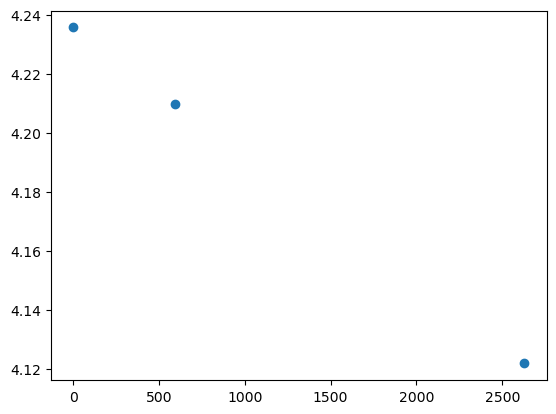

In [7]:
# Pick a random point and plot it

row = df.sample(1)
fig, ax = plt.subplots(1,1)

q_vals = [row['q_surface'].item(), row['q_1000'].item(), row['q_975'].item()]
pressure_vals = [row['msl'].item(), 1000, 975]
height_vals = [0, row['z_1000'].item(), row['z_975'].item()]
plt.scatter(height_vals, q_vals)

In [8]:
row

,index,latitude,longitude,time,mslhf,skt,v10,tp,msdwswrf,slhf,...,t2m,msnswrf,siconc,z_1000,z_975,q_1000,q_975,wind_speed,surface_stress_magnitude,q_surface
137131,245237,-47.5,109.25,2007-02-03,-54.240479,281.207306,-1.510508,0.000001,218.1875,-195281.0,...,281.227294,200.40625,0.0,590.06665,2627.488037,4.209925,4.12171,7.872468,0.093249,4.235763


In [9]:
inDt = pd.read_csv("Test_Data/data_all.csv")

In [10]:
inDt[inDt['Date'] == 20070203]

,Date,Longitude,Latitude,Wind speed,Air temperature,SST,RH,P,Rs,zu,zt
0,20070203,255.708,9.829,5.902,27.205,28.163,77.024,1008.569,198.618,10.3,10.3


In [11]:
# Get the data into the right format

In [12]:
in_df = pd.DataFrame(dict(latitude=df['latitude'],
                        longitude=df['longitude'],
                        time = df['time'],
                    spd=df['wind_speed'].to_numpy(), 
                     T=df['t2m'].to_numpy(), 
                     SST_skin=df['skt'].to_numpy(), 
                     lat=df['latitude'].to_numpy(),
                     hum=df['q_surface'].to_numpy(), 
                     P=df['msl'].to_numpy()))

In [13]:
inDt[inDt['Date'] == 20070203]

,Date,Longitude,Latitude,Wind speed,Air temperature,SST,RH,P,Rs,zu,zt
0,20070203,255.708,9.829,5.902,27.205,28.163,77.024,1008.569,198.618,10.3,10.3


In [14]:
in_df[(in_df['longitude']==255.75) & (df['latitude']==9.75)]

,latitude,longitude,time,spd,T,SST_skin,lat,hum,P
407593,9.75,255.75,2007-02-03,4.65849,300.290908,300.748322,9.75,16.231788,1009.550573


In [17]:
res_sst = AirSeaFluxCode(spd=df['wind_speed'].to_numpy(), 
                     T=df['t2m'].to_numpy(), 
                     SST=df['sst'].to_numpy(), 
                     SST_fl="bulk", 
                     meth="ecmwf", 
                     lat=df['latitude'].to_numpy(),
                     hin=np.array([10, 2]), 
                     hum=('q', df['q_surface'].to_numpy()), 
                     hout=10,
                     maxiter=50,
                     P=df['msl'].to_numpy(), 
                     cskin=1, 
                     Rs=df['msdwswrf'].to_numpy(),
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], 
                     L="tsrv", 
                     wl=1,
                     out_var = ("tau", "sensible", "latent", "cd", "rho", "uref"))
res_sst = pd.concat([df[['latitude', 'longitude']], res_sst], axis=1)
res_sst_ds = res_sst.set_index(['latitude', 'longitude']).to_xarray()

In [18]:
res_ssst = AirSeaFluxCode(spd=df['wind_speed'].to_numpy(), 
                     T=df['t2m'].to_numpy(), 
                     SST=df['skt'].to_numpy(), 
                     SST_fl="skin", 
                     meth="ecmwf", 
                     lat=df['latitude'].to_numpy(),
                     hin=np.array([10, 2]), 
                     hum=('q', df['q_surface'].to_numpy()), 
                     hout=10,
                     maxiter=50,
                     P=df['msl'].to_numpy(), 
                     cskin=0, 
                     Rs=df['msdwswrf'].to_numpy(),
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], 
                     L="tsrv", 
                     wl=1,
                     out_var = ("tau", "sensible", "latent", "cd", "rho", "uref"))
res_ssst = pd.concat([df[['latitude', 'longitude']], res_ssst], axis=1)
res_ssst_ds = res_ssst.set_index(['latitude', 'longitude']).to_xarray()

In [25]:
res_2deg = AirSeaFluxCode(spd=df_2deg['wind_speed'].to_numpy(), 
                     T=df_2deg['t2m'].to_numpy(), 
                     SST=df_2deg['skt'].to_numpy(), 
                     SST_fl="skin", 
                     meth="ecmwf", 
                     lat=df_2deg['latitude'].to_numpy(),
                     hin=np.array([10, 2]), 
                     hum=('q', df_2deg['q_surface'].to_numpy()), 
                     hout=10,
                     maxiter=50,
                     P=df_2deg['msl'].to_numpy(), 
                     cskin=0, 
                     Rs=df_2deg['msdwswrf'],
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], 
                     L="tsrv", 
                     wl=1,
                     out_var = ("tau", "sensible", "latent", "cd", "rho", "uref"))
res_2deg = pd.concat([df_2deg[['latitude', 'longitude']], res_2deg], axis=1)
res_2deg_ds = res_2deg.set_index(['latitude', 'longitude']).to_xarray()

print('Num nan tau: ', res_2deg['tau'].isna().sum(), ' / ', len(res_2deg))

Num nan tau:  11  /  10603


In [285]:
# check tau is calculated as you expect
res['tau_calc'] = ((np.power(res['uref'],2))*res['cd']*res['rho'])

Num nan:  738  /  686364


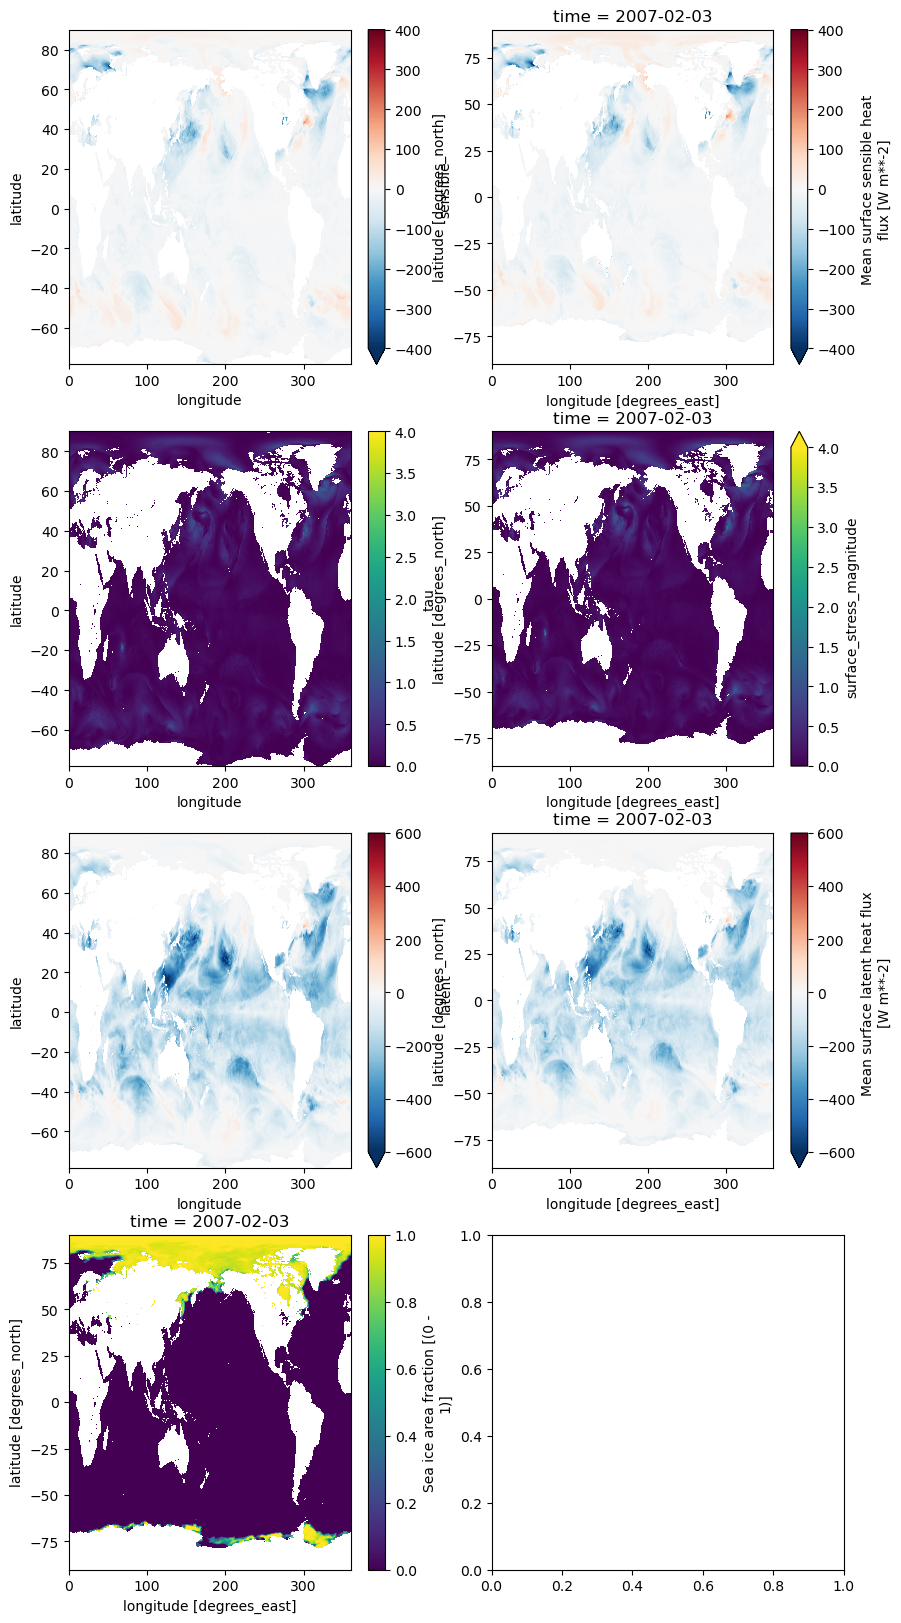

In [24]:
num_rows = 4
num_cols = 2

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
res_ssst_ds['sensible'].plot.imshow(cmap='RdBu_r', ax=ax[0,0], vmin=-400, vmax=400)
sshf_da = ds['msshf'].where(~ds['sst'].isnull())
sshf_da.plot.imshow(ax=ax[0,1], vmin=-400, vmax=400, cmap='RdBu_r',)

res_ssst_ds['tau'].plot.imshow(ax=ax[1,0], vmin=0, vmax=4)
tau_da = ds['surface_stress_magnitude'].where(~ds['sst'].isnull())
tau_da.plot.imshow(ax=ax[1,1], vmin=0, vmax=4)

res_ssst_ds['latent'].plot.imshow(ax=ax[2,0], vmin=-600, vmax=600, cmap='RdBu_r',)
tau_da = ds['mslhf'].where(~ds['sst'].isnull())
tau_da.plot.imshow(ax=ax[2,1], vmin=-600, vmax=600, cmap='RdBu_r',)

ds['siconc'].plot.imshow(ax=ax[3,0])

print('Num nan tau: ', res_ssst['tau'].isna().sum(), ' / ', len(res_ssst))

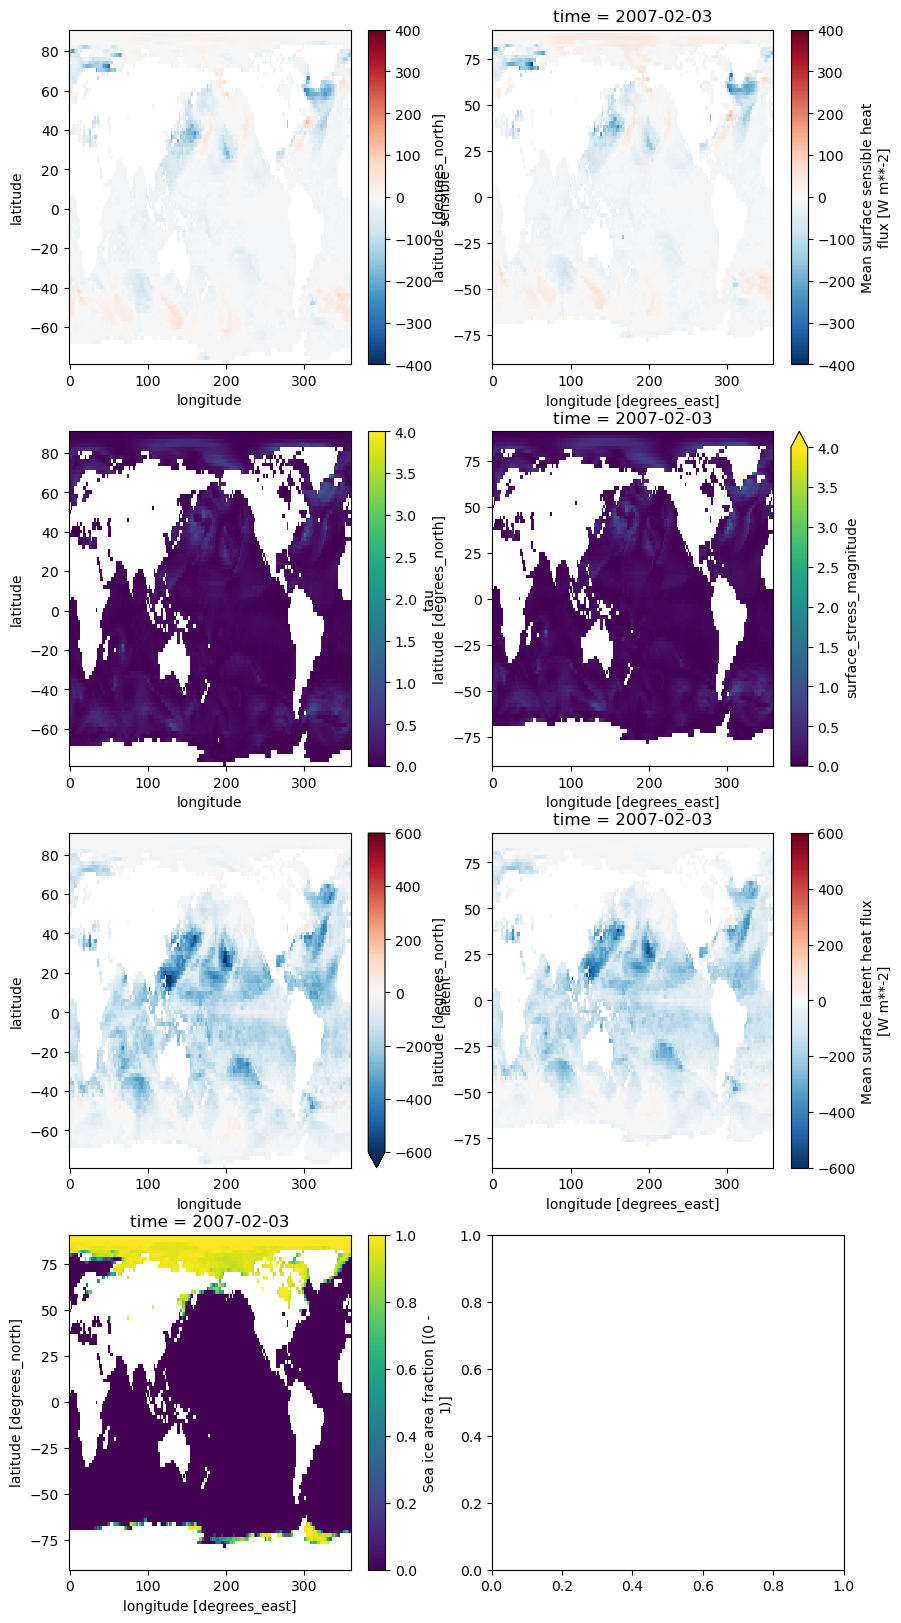

In [343]:
num_rows = 4
num_cols = 2

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
res_2deg_ds['sensible'].plot.imshow(cmap='RdBu_r', ax=ax[0,0], vmin=-400, vmax=400)
sshf_da = ds_2deg['msshf'].where(~ds_2deg['sst'].isnull())
sshf_da.plot.imshow(ax=ax[0,1], vmin=-400, vmax=400, cmap='RdBu_r',)

res_2deg_ds['tau'].plot.imshow(ax=ax[1,0], vmin=0, vmax=4)
tau_da = ds_2deg['surface_stress_magnitude'].where(~ds_2deg['sst'].isnull())
tau_da.plot.imshow(ax=ax[1,1], vmin=0, vmax=4)

res_2deg_ds['latent'].plot.imshow(ax=ax[2,0], vmin=-600, vmax=600, cmap='RdBu_r',)
tau_da = ds_2deg['mslhf'].where(~ds_2deg['sst'].isnull())
tau_da.plot.imshow(ax=ax[2,1], vmin=-600, vmax=600, cmap='RdBu_r',)

ds_2deg['siconc'].plot.imshow(ax=ax[3,0])

(array([5.83708e+05, 7.99700e+04, 1.65030e+04, 4.24000e+03, 9.72000e+02,
        1.12000e+02, 6.20000e+01, 2.40000e+01, 1.80000e+01, 1.70000e+01]),
 array([6.76329811e-11, 1.89723862e-01, 3.79447723e-01, 5.69171585e-01,
        7.58895446e-01, 9.48619308e-01, 1.13834317e+00, 1.32806703e+00,
        1.51779089e+00, 1.70751475e+00, 1.89723862e+00]),
 <BarContainer object of 10 artists>)

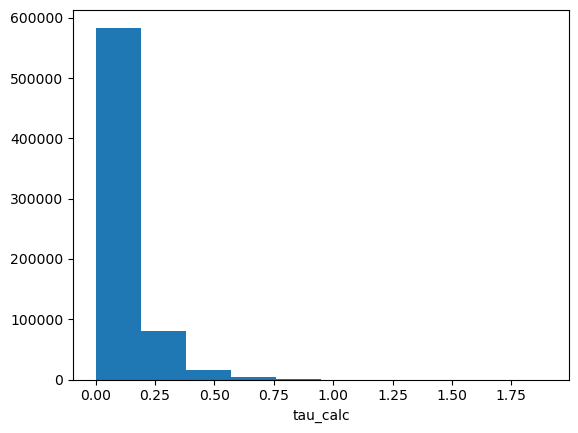

In [287]:
res_ds['tau_calc'].plot.hist()

(array([6.74653e+05, 1.13180e+04, 3.37000e+02, 4.30000e+01, 5.00000e+00,
        3.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.77088354e-04, 6.26698315e-01, 1.25321960e+00, 1.87974083e+00,
        2.50626206e+00, 3.13278317e+00, 3.75930452e+00, 4.38582563e+00,
        5.01234674e+00, 5.63886786e+00, 6.26538897e+00]),
 <BarContainer object of 10 artists>)

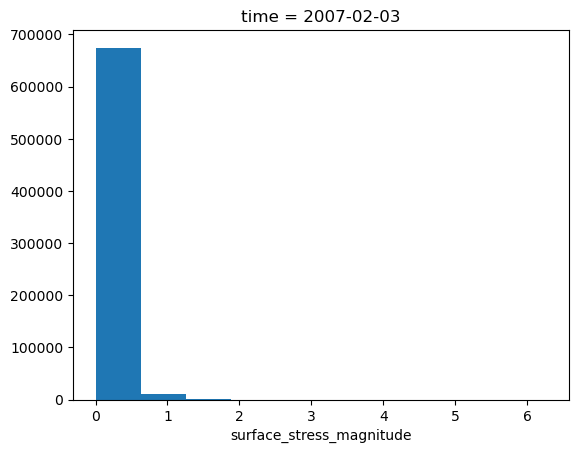

In [289]:
ds['surface_stress_magnitude'].where(~ds['sst'].isnull()).plot.hist()

In [291]:
res['tau'].max()

np.float64(2.4630059882306754)

In [290]:
ds['surface_stress_magnitude'].where(~ds['sst'].isnull()).max()

<xarray.DataArray 'surface_stress_magnitude' ()> Size: 4B
np.float32(6.265389)
Coordinates:
    time     datetime64[ns] 8B 2007-02-03

### AirSeaFluxCode examples

AirSeaFluxCode is set up to run in its default setting with a minimum number of input variables, namely wind speed; air temperature; and sea surface temperature. Let's load the code, import some real data composed for testing it (Research vessel data) and run AirSeaFluxCode with default settings (output height 10m, cool skin/warm layer corrections turned off, bulk algorithm Smith 1988, gustiness on, saturation vapour pressure following Buck (2012), tolerance limits set for both flux estimates and height adjusted variables (['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1]), number of iterations are ten, non converged points are set to missing and Monin-Obukhov stability length is calculated following the ECMWF implementation.

In [22]:
inDt = pd.read_csv("Test_Data/data_all.csv")

In [37]:
inDt = inDt[inDt['Date'] == 20070203]

In [38]:
inDt = pd.read_csv("Test_Data/data_all.csv")
date = np.asarray(inDt["Date"])
lon = np.asarray(inDt["Longitude"])
lat = np.asarray(inDt["Latitude"])
spd = np.asarray(inDt["Wind speed"])
t = np.asarray(inDt["Air temperature"])
sst = np.asarray(inDt["SST"])
rh = np.asarray(inDt["RH"])
p = np.asarray(inDt["P"])
sw = np.asarray(inDt["Rs"])
hu = np.asarray(inDt["zu"])
ht = np.asarray(inDt["zt"])
hin = np.array([hu, ht, ht])
del inDt
outvar = ("tau", "sensible", "latent", "u10n", "t10n", "q10n")
# run AirSeaFluxCode

increase_factor=100
res_baseline = AirSeaFluxCode(spd, 
                     t, 
                     sst, 
                     "bulk", 
                     meth="UA", 
                     lat=lat, 
                     hin=hin, 
                     hum=["rh", rh], 
                     hout=10.3,
                     P=p, 
                     cskin=0, 
                     Rs=sw,
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], L="tsrv", 
                     out_var = outvar)

In [36]:
t

array([27.205, 26.725, 20.799, ..., 13.066, 27.777, 28.142])

In [38]:
np.abs(res['sensible']).max()

np.float64(54.304244463585405)

In [13]:
hu

array([10.3, 10.3, 30.9, ..., 14.2, 10.6, 10.6])

In [14]:
ht

array([10.3, 10.3, 21.7, ..., 14. , 10.6, 10.6])

In [4]:
increase_factor = 100
res = AirSeaFluxCode(np.concat([spd]*increase_factor), 
                     np.concat([t]*increase_factor), 
                     np.concat([sst]*increase_factor), 
                     "bulk", 
                     meth="UA", 
                     lat=np.concat([lat]*increase_factor), 
                     hin=np.concat([hin]*increase_factor, axis=1), 
                     hum=["rh", np.concat([rh]*increase_factor)], 
                     P=np.concat([p]*increase_factor),
                     cskin=0, 
                     Rs=np.concat([sw]*increase_factor),
                     tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], L="tsrv", 
                     out_var = outvar)

res is the output of AirSeaFluxCode which is a dataFrame with keys: "tau", "sensible", "latent", "u10n", "t10n", "q10n". Let's plot the flux estimates.

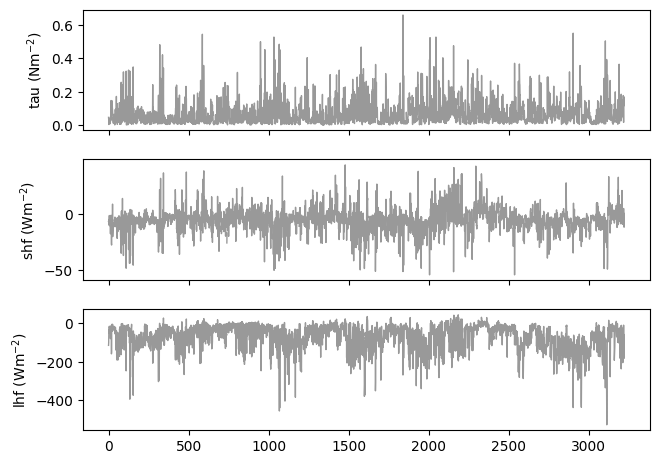

In [5]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
fig.tight_layout()
ax[0].plot(res["tau"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[1].plot(res["sensible"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[2].plot(res["latent"], "-", color="grey", linewidth=1, alpha = 0.8)
ax[0].set_ylabel('tau (Nm$^{-2}$)')
ax[1].set_ylabel('shf (Wm$^{-2}$)')
ax[2].set_ylabel('lhf (Wm$^{-2}$)')
plt.show()

You can save the output in a csv file

In [6]:
res.to_csv("test_AirSeaFluxCode.csv")

and generate some statistics which you can save in a txt file

In [7]:
print("Input summary", file=open('./stats.txt', 'a'))
print('input file name: {}, \n method: {}, \n gustiness: {}, \n cskin: {},'
      ' \n tolerance: {}, \n qmethod: {}, \n L: {}'.format("data_all.csv", "UA", "on",
                                                           0, "all", "Buck2", "Rb"),
      file=open('./stats.txt', 'a'))
ttl = np.asarray(["tau  ", "shf  ", "lhf  ", "u10n ", "t10n ", "q10n "])
header = ["var", "mean", "median", "min", "max", "5%", "95%"]
n = np.shape(res)
stats = np.copy(ttl)
a = res.iloc[:,:-1].to_numpy(dtype="float64").T
stats = np.c_[stats, np.nanmean(a, axis=1)]
stats = np.c_[stats, np.nanmedian(a, axis=1)]
stats = np.c_[stats, np.nanmin(a, axis=1)]
stats = np.c_[stats, np.nanmax(a, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 5, axis=1)]
stats = np.c_[stats, np.nanpercentile(a, 95, axis=1)]
print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
               floatfmt=("s", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e", "2.2e")),
      file=open('./stats.txt', 'a'))
print('-'*79+'\n', file=open('./stats.txt', 'a'))
del a